In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from google.colab import files
import PyPDF2

In [4]:
# Download NLTK data if not available
nltk.download('stopwords')
nltk.download('wordnet')

# ====================================
# Load Dataset from Google Colab Folder
# ====================================
print("Loading dataset from Colab folder...")
dataset_path = "/content/drive/MyDrive/Sem 3/Fair_Hiring_Solution_Dataset.csv"  # Modify this path if needed
df = pd.read_csv(dataset_path)

print("Dataset loaded, preprocessing data...")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Loading dataset from Colab folder...
Dataset loaded, preprocessing data...


In [5]:
# Drop unnecessary columns if they exist
df = df.drop(columns=['Candidate ID', 'Name', 'Resume Text', 'Comments/Notes'], errors='ignore')

# Display available columns
print(f"Columns available in dataset: {df.columns.tolist()}")

# General description of the dataset
print("\nGeneral description of the dataset:")
print(df.describe(include='all'))

# Count the number of missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())

Columns available in dataset: ['Age', 'Gender', 'Disability Type', 'Years of Experience', 'Education Level', 'Skills', 'Previous Employment', 'AI Model Decision', 'Discrimination Flags', 'Hiring Decision']

General description of the dataset:
                  Age  Gender Disability Type  Years of Experience  \
count   100000.000000  100000           79778        100000.000000   
unique            NaN       3               2                  NaN   
top               NaN    Male          Ataxia                  NaN   
freq              NaN   33392           59274                  NaN   
mean        40.030310     NaN             NaN            19.542010   
std         11.237989     NaN             NaN            11.550778   
min         21.000000     NaN             NaN             0.000000   
25%         30.000000     NaN             NaN            10.000000   
50%         40.000000     NaN             NaN            20.000000   
75%         50.000000     NaN             NaN            

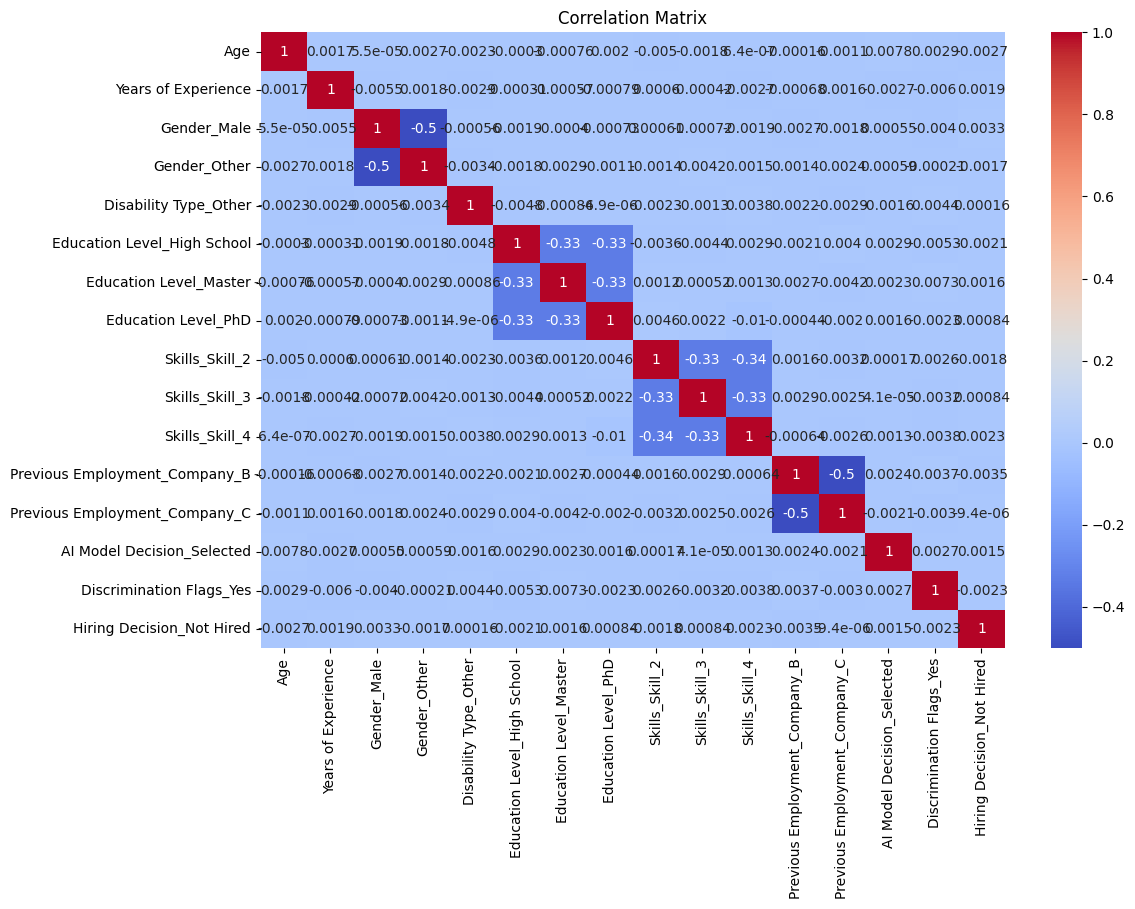

In [6]:
# Fill missing values with the median or mode (depending on the data type)
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Correlation Matrix
corr_matrix = df.corr()

# Visualization of Correlation Matrix
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

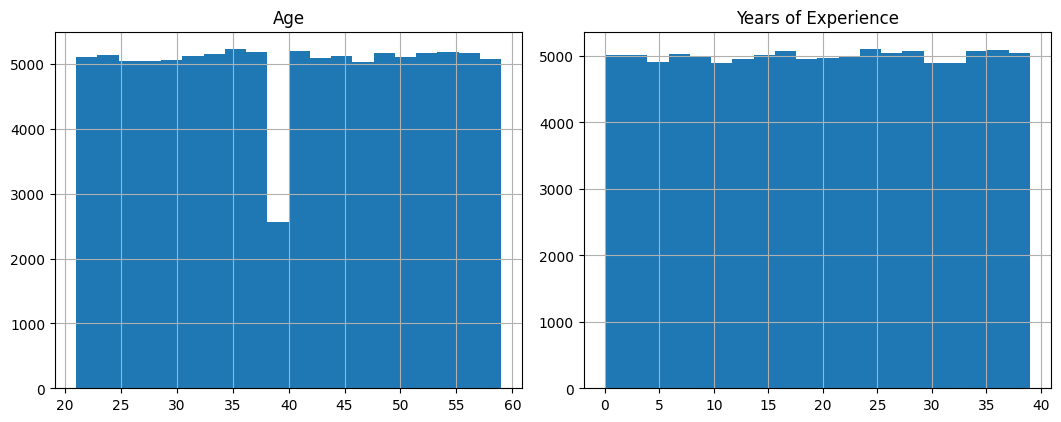

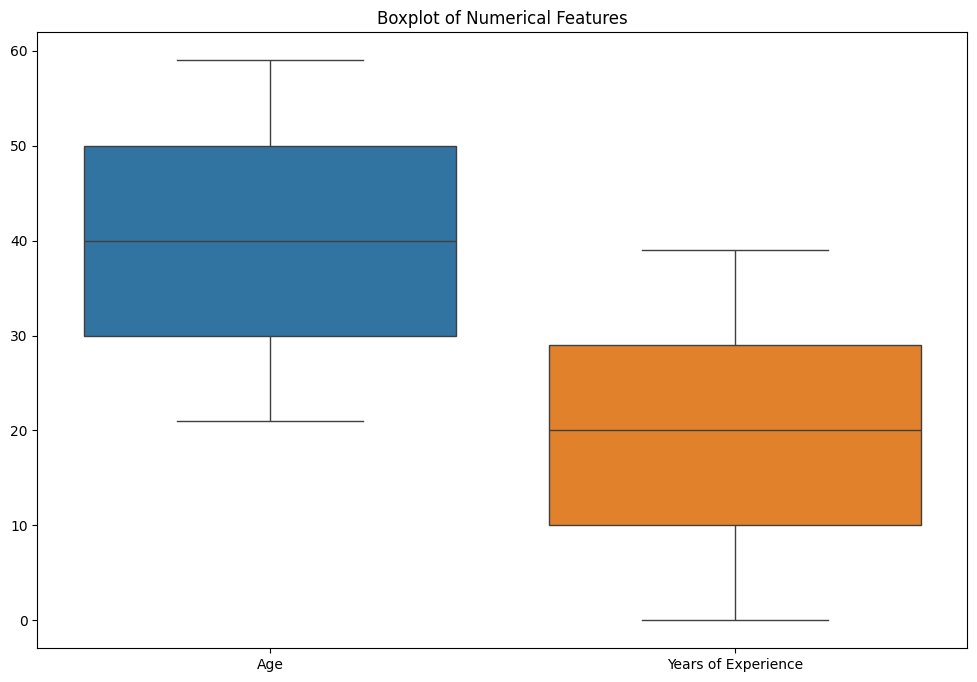

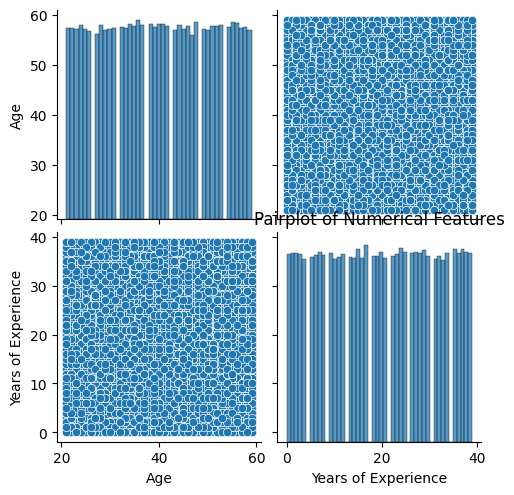


Tuning model hyperparameters...

Best Hyperparameters: {'C': 1, 'max_iter': 500, 'solver': 'liblinear'}

Train Accuracy: 0.5053111152717968
Test Accuracy: 0.4964801038494183


In [7]:
# Distribution of numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Histograms for numerical columns
df[numerical_columns].hist(figsize=(16, 12), bins=20, layout=(3,3))
plt.tight_layout()
plt.show()

# Boxplot for numerical columns
plt.figure(figsize=(12,8))
sns.boxplot(data=df[numerical_columns])
plt.title('Boxplot of Numerical Features')
plt.show()

# Pairplot for numerical features (only if less than 10 numerical features)
if len(numerical_columns) <= 10:
    sns.pairplot(df[numerical_columns])
    plt.title('Pairplot of Numerical Features')
    plt.show()

# Check for hiring decision column
decision_columns = [col for col in df.columns if 'Hiring Decision' in col]

if decision_columns:
    y = df[decision_columns[0]]
    X = df.drop(columns=decision_columns, errors='ignore')

    # Handle Class Imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Scale the features
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # =======================================
    # Hyperparameter Tuning with GridSearchCV
    # =======================================
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [500, 1000, 2000]
    }

    print("\nTuning model hyperparameters...")
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("\nBest Hyperparameters:", grid_search.best_params_)

    # Predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Model accuracy
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f"\nTrain Accuracy: {accuracy_train}")
    print(f"Test Accuracy: {accuracy_test}")


Classification Report (Test Set):
              precision    recall  f1-score   support

       False       0.50      0.53      0.51     10003
        True       0.50      0.46      0.48     10026

    accuracy                           0.50     20029
   macro avg       0.50      0.50      0.50     20029
weighted avg       0.50      0.50      0.50     20029



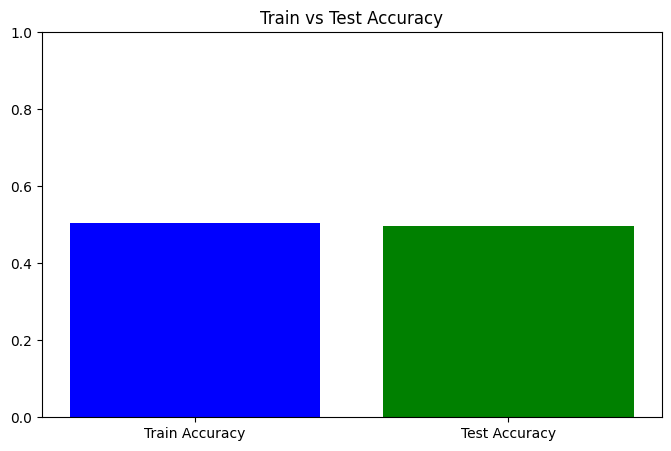

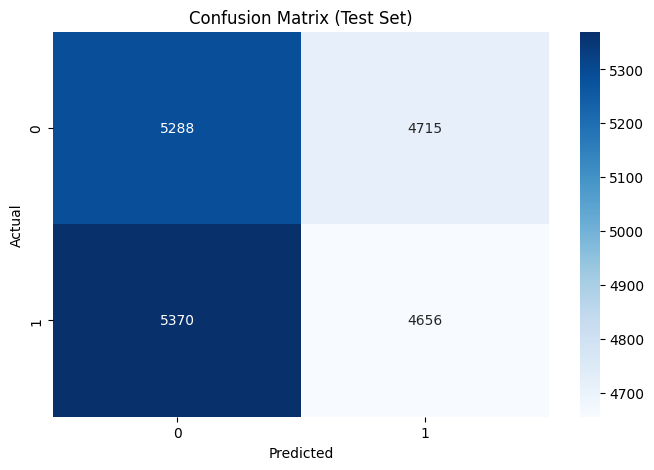

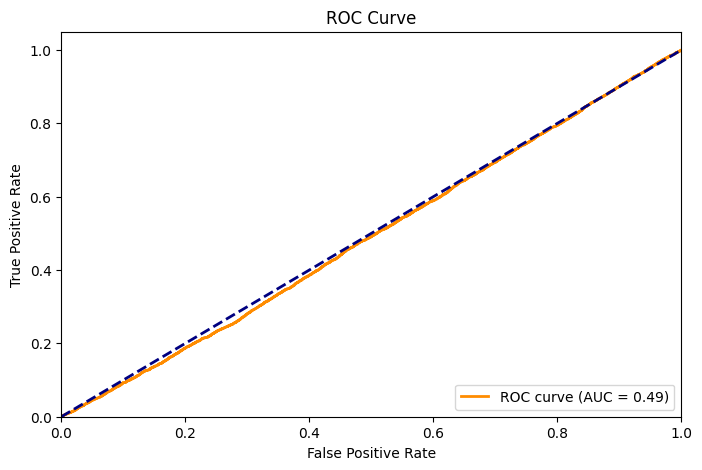

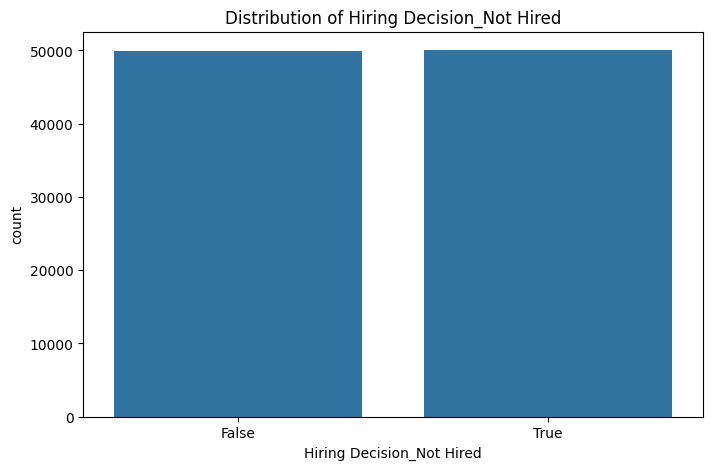

In [8]:

    # Confusion matrix for test set
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)

    # Classification report
    class_report_test = classification_report(y_test, y_pred_test)
    print("\nClassification Report (Test Set):")
    print(class_report_test)

    # ROC Curve and AUC
    y_prob_test = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    auc_score = roc_auc_score(y_test, y_prob_test)

    # Visualization of Train vs Test Accuracy
    plt.figure(figsize=(8,5))
    plt.bar(['Train Accuracy', 'Test Accuracy'], [accuracy_train, accuracy_test], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title('Train vs Test Accuracy')
    plt.show()

    # Confusion Matrix
    plt.figure(figsize=(8,5))
    sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Distribution of the target variable
    plt.figure(figsize=(8,5))
    sns.countplot(x=y)
    plt.title(f'Distribution of {decision_columns[0]}')
    plt.show()


In [9]:
# ======================================
# DISABILITY DETECTION FROM RESUME
# ======================================

# NLP Preprocessing function
def preprocess_text(text):
    """
    Preprocesses text by removing special characters, converting to lowercase, and lemmatizing.
    """
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Function to extract text from PDF
def extract_text_from_pdf(pdf_file):
    """
    Extracts text from a PDF file using PyPDF2.
    """
    try:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        extracted_text = ''
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            extracted_text += page.extract_text()
        return extracted_text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return ""

# Function to extract name from resume
def extract_name(resume_text):
    """
    A basic heuristic to extract the name (first and last word of the resume).
    """
    lines = resume_text.strip().split('\n')
    if len(lines) > 0:
        # Assuming the first line of the resume contains the name
        name = lines[0].strip()
        return name
    return "Unknown"

# Function to check for disabilities and identify if the person is normal
def check_resume_for_disabilities(resume_text):
    """
    Detects disabilities such as Ataxia, Visual Impairment, and others in a given resume text.
    """
    # Preprocess the resume text
    cleaned_text = preprocess_text(resume_text)

    # Check if the resume explicitly states that there is no disability
    if "Disability: None" in resume_text:
        print("\nThis is a normal person with no disabilities.")
        return "No Disability Detected"

    # Check if there is no mention of any disability at all
    if "disability" not in cleaned_text.lower():
        print("\nNo mention of disabilities found in the resume. Treating as normal.")
        return "No Disability Detected"

    # Keywords and phrases related to disabilities (you can add more here)
    disability_keywords = {
        'ataxia': r'\bataxia\b|difficulty\swith\scoordination|difficulty\swith\sbalance',
        'visual impairment': r'\bvisual\simpairment\b|vision\simpairment|sight\simpairment',
        'blindness': r'\bblindness\b',
        'deafness': r'\bdeafness\b|hearing\simpairment|hard\sof\shearing',
        'paraplegia': r'\bparaplegia\b',
        'cerebral palsy': r'\bcerebral\spalsy\b',
        'autism': r'\bautism\b|autistic\sspectrum\sdisorder'
    }

    # Initialize variables to track detected disabilities
    detected_disabilities = []

    # Check the cleaned text for each disability keyword/phrase
    for disability, pattern in disability_keywords.items():
        if re.search(pattern, cleaned_text, re.IGNORECASE):
            detected_disabilities.append(disability)

    # Extract name from the resume
    name = extract_name(resume_text)

    # If Ataxia is detected, print the full resume
    if 'ataxia' in detected_disabilities:
        print(f"\nThis person, {name}, is diagnosed with Ataxia based on the resume content.")
        print(f"Full resume content:\n{resume_text}")
        return "Ataxia Detected"

    # Decision-making based on other detected disabilities
    if detected_disabilities:
        print(f"\nThis person, {name}, has a disability: {', '.join(detected_disabilities)}.")
        return f"This person, {name}, is disabled."
    else:
        print(f"\nThis is a normal person with no disabilities detected.")
        return "No Disability Detected"

# =====================================
# Reading Resume and Analyzing Text
# =====================================
print("\nPlease upload a resume file (TXT or PDF) for analysis:")
resume_uploaded = files.upload()

resume_filename = list(resume_uploaded.keys())[0]

# Handle different file types (PDF and TXT)
if resume_filename.endswith('.pdf'):
    resume_text = extract_text_from_pdf(resume_filename)
elif resume_filename.endswith('.txt'):
    with open(resume_filename, 'r', encoding='utf-8') as file:
        resume_text = file.read()

# Check if text extraction was successful
if resume_text:
    # Check the resume for disabilities
    disability_result = check_resume_for_disabilities(resume_text)

    # Additional decisions based on the detection (example: auto-reject for disabilities, or manual review)
    if disability_result == "Ataxia Detected":
        print("This candidate is eligible for the job.")
    elif "disabled" in disability_result:
        print(f"{disability_result}. Manual review required.")
    else:
        print("This is a normal candidate with no disability, proceed as usual.")
else:
    print("No text could be extracted from the file.")



Please upload a resume file (TXT or PDF) for analysis:


Saving Resume_John_Doe.pdf to Resume_John_Doe.pdf

This person, Name: John Doe, is diagnosed with Ataxia based on the resume content.
Full resume content:
Name: John Doe
Age: 34
Gender: Male
Education: Bachelor of Science in Computer Science
Experience: 10 years as a Software Engineer
Skills: Python, Java, C++, SQL
Disability: Ataxia - Difficulty with coordination and balance
Summary: Experienced software engineer with expertise in backend development and database
management. Currently seeking opportunities that allow for flexible working conditions.
This candidate is eligible for the job.
